In [1]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F 
from pyspark import SparkConf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.master("local[2]").appName("airline").config("spark.some.config.option", "some-value").getOrCreate()
airline_df=spark.read.format('csv').option("header","true").load("file:////SoftWare/pysparkTest/0407/airline_2019.csv")

/root/anaconda3/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [3]:
airline_df.show(5)

+----------+---------------------+--------+------+----------------+---------------+----+--------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER_AIRLINE_ID|TAIL_NUM|ORIGIN|ORIGIN_CITY_NAME|ORIGIN_STATE_NM|DEST|DEST_CITY_NAME|DEST_STATE_NM|CRS_DEP_TIME|DEP_TIME|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|CANCELLED|CANCELLATION_CODE|DIVERTED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 25|
+----------+---------------------+--------+------+----------------+---------------+----+--------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|2019-04-01|                20416|

In [20]:
from pyspark.sql.types import *
airline_df = airline_df.filter(airline_df.ARR_TIME. isNotNull()).filter(airline_df.CRS_ARR_TIME. isNotNull())
airline_df.count()

7231618

In [21]:
#采样 20%的数据来分析
df=airline_df.sample(0.2,2022)

In [22]:
df.count()

1447485

In [7]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import matplotlib.pyplot as pyplot
import seaborn as sns
import ast, json
import glob
%matplotlib inline  

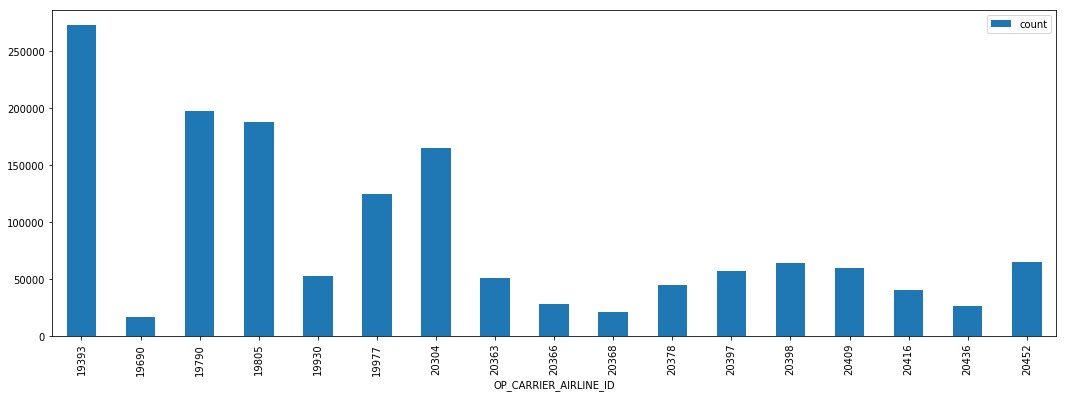

In [8]:
df.groupBy("OP_CARRIER_AIRLINE_ID").count().sort("OP_CARRIER_AIRLINE_ID", ascending=True).toPandas().plot.bar(x='OP_CARRIER_AIRLINE_ID',figsize=(18, 6))

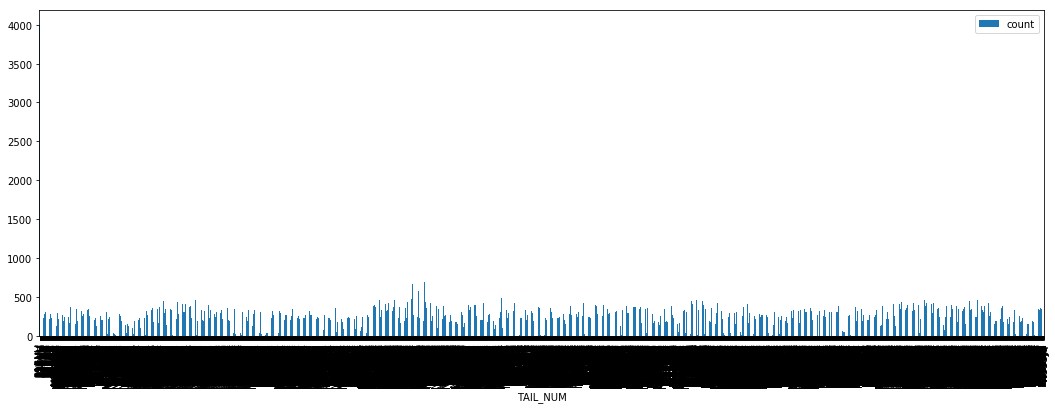

In [9]:
df.groupBy("TAIL_NUM").count().sort("TAIL_NUM", ascending=True).toPandas().plot.bar(x='TAIL_NUM',figsize=(18, 6))

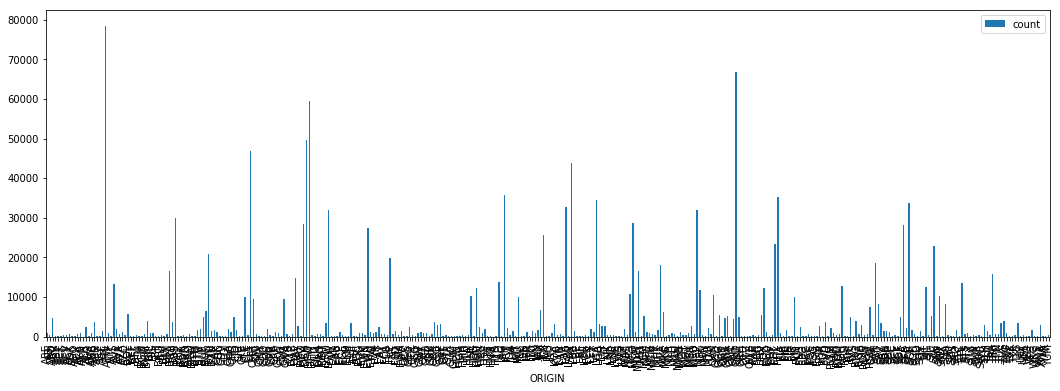

In [10]:
df.groupBy("ORIGIN").count().sort("ORIGIN", ascending=True).toPandas().plot.bar(x='ORIGIN',figsize=(18, 6))

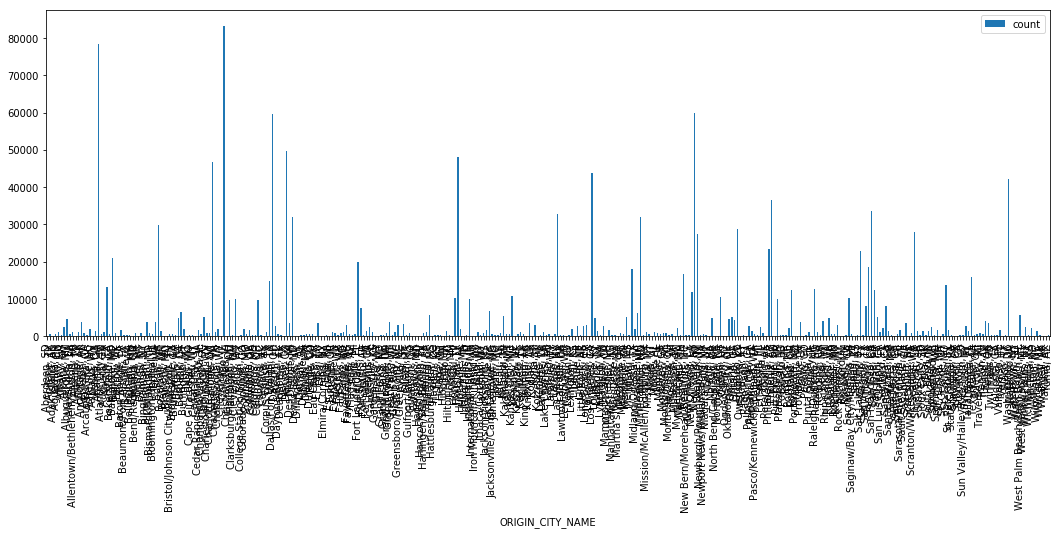

In [11]:
df.groupBy("ORIGIN_CITY_NAME").count().sort("ORIGIN_CITY_NAME", ascending=True).toPandas().plot.bar(x='ORIGIN_CITY_NAME',figsize=(18, 6))

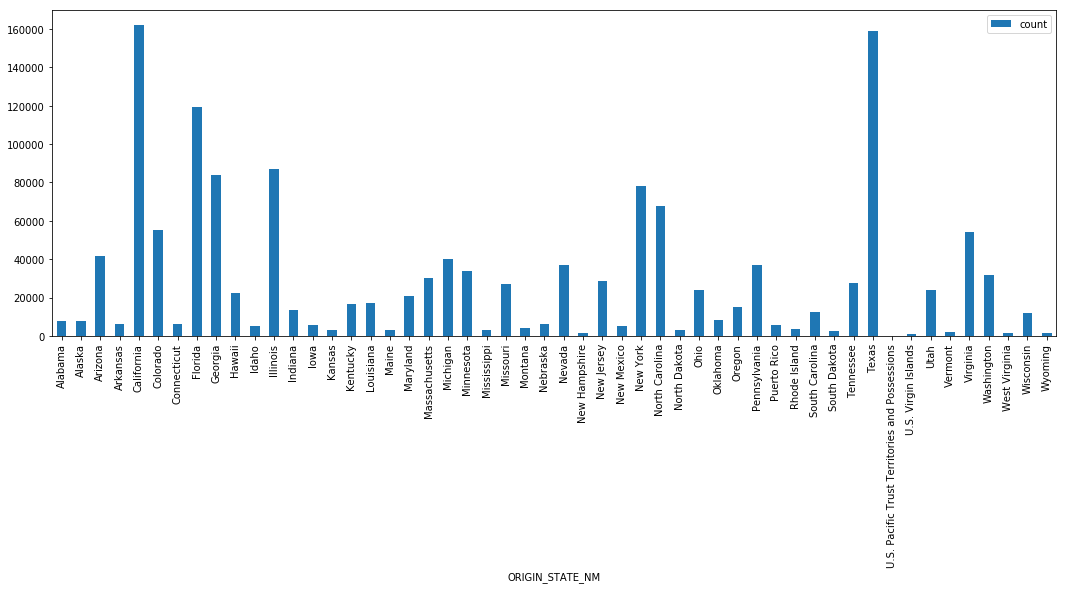

In [12]:
df.groupBy("ORIGIN_STATE_NM").count().sort("ORIGIN_STATE_NM", ascending=True).toPandas().plot.bar(x='ORIGIN_STATE_NM',figsize=(18, 6))

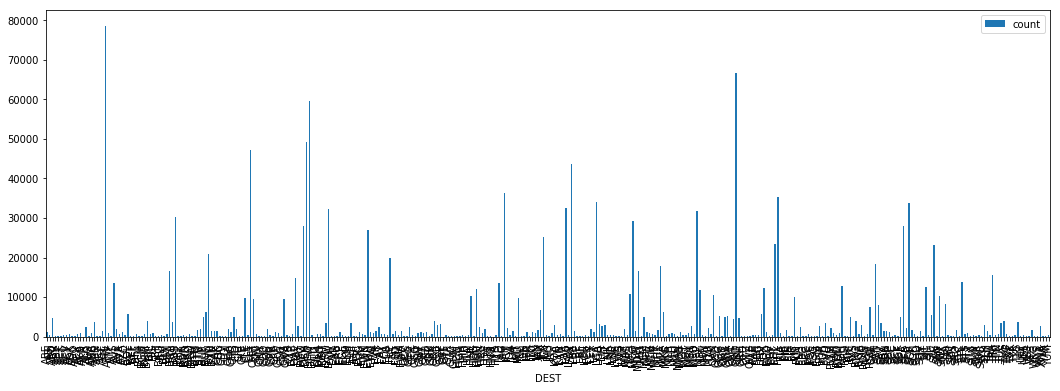

In [13]:
df.groupBy("DEST").count().sort("DEST", ascending=True).toPandas().plot.bar(x='DEST',figsize=(18, 6))

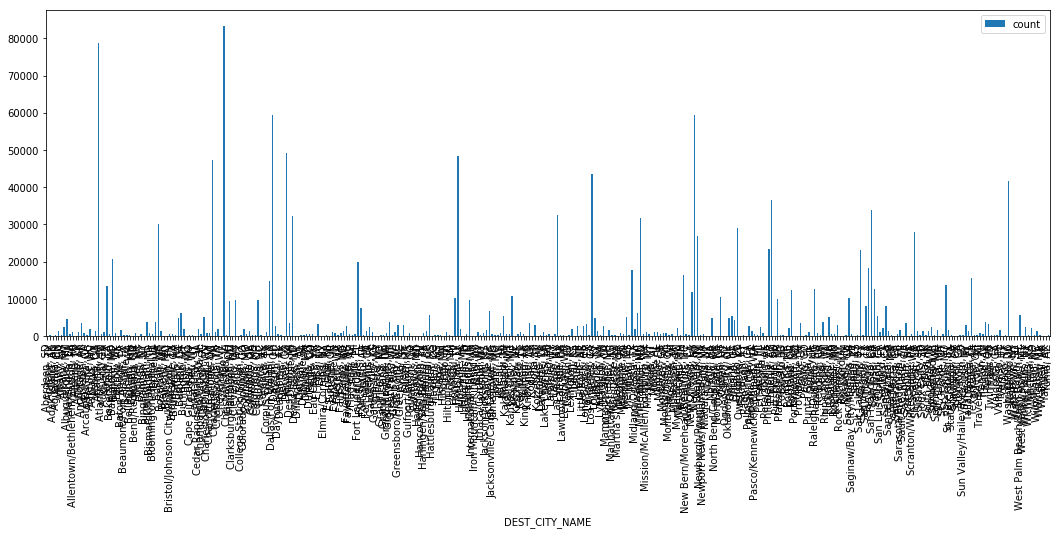

In [14]:
df.groupBy("DEST_CITY_NAME").count().sort("DEST_CITY_NAME", ascending=True).toPandas().plot.bar(x='DEST_CITY_NAME',figsize=(18, 6))

In [15]:
df.groupBy("DEST_STATE_NM").count().sort("DEST_STATE_NM", ascending=True).toPandas().plot.bar(x='DEST_STATE_NM',figsize=(18, 6))

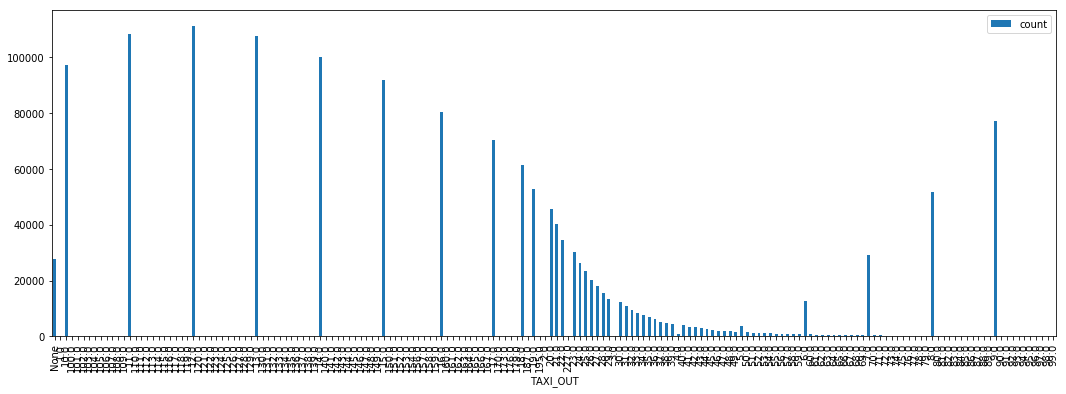

In [16]:
df.groupBy("TAXI_OUT").count().sort("TAXI_OUT", ascending=True).toPandas().plot.bar(x='TAXI_OUT',figsize=(18, 6))

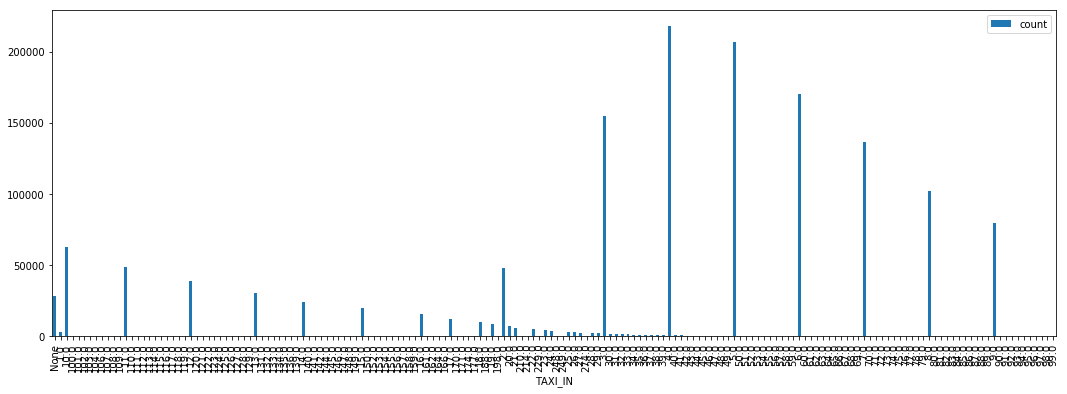

In [17]:
df.groupBy("TAXI_IN").count().sort("TAXI_IN", ascending=True).toPandas().plot.bar(x='TAXI_IN',figsize=(18, 6))

In [66]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
def calcul(model,train,test):
    predictions_train = model.transform(train)
    predictions_test = model.transform(test)
    evaluator = BinaryClassificationEvaluator()
    print('train AUC：', evaluator.evaluate(predictions))
    print('test AUC：', evaluator.evaluate(predictions))

In [46]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer = StringIndexer(inputCols=['OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_NM','DEST'
                                  ,'DEST_CITY_NAME','DEST_STATE_NM','TAXI_OUT','TAXI_IN'], 
                        outputCols=['OP_CARRIER_AIRLINE_ID_index', 'TAIL_NUM_index', 'ORIGIN_index','ORIGIN_CITY_NAME_index','ORIGIN_STATE_NM_index','DEST_index'
                                  ,'DEST_CITY_NAME_index','DEST_STATE_NM_index','TAXI_OUT_index','TAXI_IN_index'])
# indexed = indexer.fit(df).transform(df)
# indexed.show(3)
# indexer.setHandleInvalid("skip")
indexer.setHandleInvalid("keep")
encoder = OneHotEncoder(inputCols=['OP_CARRIER_AIRLINE_ID_index', 'TAIL_NUM_index', 'ORIGIN_index','ORIGIN_CITY_NAME_index','ORIGIN_STATE_NM_index','DEST_index'
                                  ,'DEST_CITY_NAME_index','DEST_STATE_NM_index','TAXI_OUT_index','TAXI_IN_index'],
                        outputCols=['OP_CARRIER_AIRLINE_ID_vec', 'TAIL_NUM_vec', 'ORIGIN_vec','ORIGIN_CITY_NAME_vec','ORIGIN_STATE_NM_vec','DEST_vec'
                                  ,'DEST_CITY_NAME_vec','DEST_STATE_NM_vec','TAXI_OUT_vec','TAXI_IN_vec'])
# model = encoder.fit(indexed)
# encoded_df = model.transform(indexed)
# encoded_df.show(3)

In [47]:
from pyspark.ml.feature import VectorAssembler
combine_vector = VectorAssembler(inputCols =['OP_CARRIER_AIRLINE_ID_vec', 'TAIL_NUM_vec', 'ORIGIN_vec','ORIGIN_CITY_NAME_vec','ORIGIN_STATE_NM_vec','DEST_vec'
                                  ,'DEST_CITY_NAME_vec','DEST_STATE_NM_vec','TAXI_OUT_vec','TAXI_IN_vec'], 
                                   outputCol = 'features')

In [33]:
from pyspark.sql.types import *
def target_normal(ARR_TIME,CRS_ARR_TIME):
    if float(ARR_TIME)-float(CRS_ARR_TIME)>0:
        return 1
    else:
        return 0
target_normal_udf = F.udf(lambda x,y:target_normal(x,y),IntegerType())
df=df.withColumn("label", target_normal_udf(df["ARR_TIME"],df["CRS_ARR_TIME"]))

In [40]:
df = df.filter(df.label. isNotNull())
df.count()

1447485

In [48]:
from pyspark.ml import Pipeline
feature_engineering_pipe = Pipeline(stages=[indexer,encoder,combine_vector])

In [49]:
splits = df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [50]:
feature_engineering_model=feature_engineering_pipe.fit(train_df)

In [51]:
train_df_feature=feature_engineering_model.transform(train_df)
test_df_feature=feature_engineering_model.transform(test_df)

In [52]:
#测试 逻辑回归效果
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

In [53]:
lrModel = lr.fit(train_df_feature)

In [65]:
calcul(lrModel,train_df_feature,test_df_feature)

train AUC： 0.7068398280872225
test AUC： 0.7068389929657632


In [56]:
#测试 决策树效果
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dtModel=dt.fit(train_df_feature)

In [67]:
calcul(dtModel,train_df_feature,test_df_feature)

train AUC： 0.7068390192039464
test AUC： 0.7068394636397084


In [57]:
#测试 RandomForest效果
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier()
rfModel=rf.fit(train_df_feature)

In [68]:
calcul(rfModel,train_df_feature,test_df_feature)

train AUC： 0.7068395909367463
test AUC： 0.7068397974578132


In [58]:
#测试gbdt的效果
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier()
gbtModel=gbt.fit(train_df_feature)

In [69]:
calcul(gbtModel,train_df_feature,test_df_feature)

train AUC： 0.7068375138503593
test AUC： 0.7068392242450974
